<a href="https://colab.research.google.com/github/shuyuexu/4994finalproj-stage1/blob/main/aml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Tokenizer():
    
    def __init__(self):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        
    def fit(self, arr):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        for word in arr:
            if word not in self.word_index:
                self.index_word[self.vocab_size] = word
                self.word_index[word] = self.vocab_size
                self.vocab_size += 1
                    
    def transform(self, sentence):
        return [0] + [self.word_index[word] for word in sentence] + [1]
    
    def reverse_transform(self, encoded_sentence):
        return [self.index_word[num] for num in encoded_sentence[1:-1]]

In [2]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ImgCapDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        self.image_transform = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_1 = os.path.join(self.img_dir, self.df.iloc[idx]["Image1"] + ".png")
        img_1 = Image.open(img_1)
        img_1 = self.image_transform(img_1)
        
        img_2 = os.path.join(self.img_dir, self.df.iloc[idx]["Image2"] + ".png")
        img_2 = Image.open(img_2)
        img_2 = self.image_transform(img_2)
        
        caption = torch.LongTensor(self.df.iloc[idx]["CaptionSeq"])

        return img_1, img_2, caption

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
from torchvision.models import densenet121

class CNN_Encoder(nn.Module):
    
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc = nn.Linear(256*256*16, 128)

        self.conv2 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc2 = nn.Linear(256*256*16, 128)

    def forward(self, x1, x2):
        x1 = F.relu(self.conv(x1))
        x1 = F.max_pool2d(x1, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fc(x1)

        x2 = F.relu(self.conv2(x2))
        x2 = F.max_pool2d(x2, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fc2(x2)

        return torch.cat((x1, x2), 1)
    
class VGG_Encoder(nn.Module):
    
    def __init__(self):
        super(VGG_Encoder, self).__init__()
        self.vgg1 = vgg16(pretrained=True)
        seq1 = list(self.vgg1.classifier)
        seq1[-1] = nn.Linear(4096, 1024, bias=True)
        seq1.append(nn.ReLU(inplace=True))
        seq1.append(nn.Dropout(p=0.5, inplace=False))
        seq1.append(nn.Linear(1024, 128, bias=True))
        self.vgg1.classifier = nn.Sequential(*seq1)
        
        for param in self.vgg1.features.parameters():
            param.requires_grad = False
        
        self.vgg2 = vgg16(pretrained=True)
        seq2 = list(self.vgg2.classifier)
        seq2[-1] = nn.Linear(4096, 1024, bias=True)
        seq2.append(nn.ReLU(inplace=True))
        seq2.append(nn.Dropout(p=0.5, inplace=False))
        seq2.append(nn.Linear(1024, 128, bias=True))
        self.vgg2.classifier = nn.Sequential(*seq2)
        
        for param in self.vgg2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.vgg1(x1)
        x2 = self.vgg2(x2)
        
        return torch.cat((x1, x2), 1)
    
class DN_Encoder(nn.Module):
    
    def __init__(self):
        super(DN_Encoder, self).__init__()
        self.dn1 = densenet121(pretrained=True)
        #model = model_class.from_pretrained(pretrained_weights, force_download=True)
        #self.dn1.load_state_dict(torch.load("m-30012020-104001.pth.tar"))
        checkpoint = torch.load("m-30012020-104001.pth.tar")
        self.dn1.load_state_dict(checkpoint['state_dict'],strict=False )
        self.dn1.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn1.features.parameters():
            param.requires_grad = False
        
        self.dn2 = densenet121(pretrained=True)
        #self.dn2.load_state_dict(torch.load("m-30012020-104001.pth"))
        self.dn2.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.dn1(x1)
        x2 = self.dn2(x2)
        
        return torch.cat((x1, x2), 1)
        

class RNN_Decoder(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTMCell(embed_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, caption):

        cap = torch.transpose(self.embed(caption), 0, 1)
        output = torch.empty((caption.size(0), caption.size(1), self.vocab_size))

        for i in range(caption.size(1)):

            if i == 0:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                h = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                c = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                h, c = self.rnn(x, (h ,c))
            else:
                h, c = self.rnn(cap[i,:,:], (h, c))

            output[:,i,:] = self.fc(h)

        return output

In [4]:
!pip install biobert-embedding

     |████████████████████████████████| 748.9 MB 704 bytes/s 
     |████████████████████████████████| 123 kB 48.3 MB/s 
     |████████████████████████████████| 131 kB 52.5 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 8.4 MB 35.1 MB/s 
     |████████████████████████████████| 138 kB 38.6 MB/s 
     |████████████████████████████████| 127 kB 53.1 MB/s 
  Created wheel for biobert-embedding: filename=biobert_embedding-0.1.2-py3-none-any.whl size=5701 sha256=4c1ea5be895a5985b1f14c3042befe5cfb61441316dd5b4913c9f67878a01302
  Stored in directory: /root/.cache/pip/wheels/67/26/c2/176e174845e1612a5d607eea1d1876e2c9aca2b5654a5cd681
Successfully built biobert-embedding
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:

In [116]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from biobert_embedding.embedding import BiobertEmbedding

class BaseModel():
    
    def __init__(self, train_df, test_df,image_address, sentence_length, vocab_size, epoch, encoder_name):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.df = df.sample(frac=1).reset_index(drop=True)

        test_df = test_df.sample(frac=1).reset_index(drop=True)
        train_df= train_df.sample(frac=1).reset_index(drop=True)
        train_df, val_df = self.train_val_split(train_df)
        
        train_ds = ImgCapDataset(train_df, image_address)
        val_ds = ImgCapDataset(val_df, image_address)
        test_ds = ImgCapDataset(test_df, image_address)
        
        self.train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
        self.val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
        self.test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)
        
        self.EPOCH = epoch
        
        if encoder_name == "CNN":
            self.encoder = CNN_Encoder()
        elif encoder_name == "VGG":
            self.encoder = VGG_Encoder()
        elif encoder_name == "DenseNet":
            self.encoder = DN_Encoder()
        self.decoder = RNN_Decoder(256, sentence_length, vocab_size)
        
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        
        self.encoder_optim = torch.optim.Adam(self.encoder.parameters(), 0.0001)
        self.decoder_optim = torch.optim.Adam(self.decoder.parameters(), 0.0001)
        self.LOSS = torch.nn.CrossEntropyLoss()
        
    def train_val_split(self, df):

        split = 4*len(df)//5
        train = df.iloc[:split,:]
        val = df.iloc[split:,:]
        return train, val
    
    def train(self):
        self._training_loop(
            self.EPOCH, self.encoder, self.decoder, self.encoder_optim, 
            self.decoder_optim, self.LOSS, self.train_dl, self.val_dl
        )
        
    def _training_loop(self, epochs, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_f, train_loader, val_loader):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        for epoch in range(epochs):
            loss_train = 0.0
            for x1, x2, y in train_loader:
                x1 = x1.to(device)
                x2 = x2.to(device)
                y = y.to(device)
                
                out = encoder(x1, x2)
                out = decoder(out, y)
                out = out.to(device)
                loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))

                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                loss_train += loss.item()
            
            with torch.no_grad():
                loss_val = 0.0
                for x1, x2, y in val_loader:
                    x1 = x1.to(device)
                    x2 = x2.to(device)
                    y = y.to(device)

                    out = encoder(x1, x2)
                    out = decoder(out, y)
                    out = out.to(device)
                    loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))
                    loss_val += loss.item()
                print("Epoch", epoch, "Train Loss", loss_train/len(train_loader), "Validation Loss", loss_val/len(val_loader))
    
    def sample(self, tokenizer):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x1, x2, c = next(iter(self.test_dl))
        x1 = x1.to(device)
        x2 = x2.to(device)
        c = c.to(device)
        out1 = self.encoder.forward(x1, x2)
        out2 = self.decoder.forward(out1, c)
        encoded_out = torch.argmax(out2, dim=2).cpu().detach().numpy()

        decoded_out = " ".join([tokenizer.index_word[x] for x in encoded_out[0] if x not in (0, 1)])
            
        c = c.cpu().detach().numpy()
            
        real = " ".join([tokenizer.index_word[x] for x in c[0] if x not in (0, 1)])

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(x1[0].permute(1, 2, 0).cpu().detach().numpy())
        ax[1].imshow(x2[0].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
        print("Prediction:", decoded_out)
        print("Caption:", real)
        
    def evaluate(self, tokenizer):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dist = []
        for x1, x2, c in self.test_dl:
            x1 = x1.to(device)
            x2 = x2.to(device)
            c = c.to(device)
            out1 = self.encoder.forward(x1, x2)
            out2 = self.decoder.forward(out1, c)
            encoded_out = torch.argmax(out2, dim=2).cpu().detach().numpy()

            decoded_out = " ".join([tokenizer.index_word[x] for x in encoded_out[0] if x not in (0, 1)])
            c = c.cpu().detach().numpy()
            real = " ".join([tokenizer.index_word[x] for x in c[0] if x not in (0, 1)])

            biobert = BiobertEmbedding()
            preds = biobert.sentence_vector(decoded_out)
            caps = biobert.sentence_vector(real)
            dist.append(cosine(preds, caps))
            
        return np.mean(dist)
        

In [21]:
   
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext.data.metrics import bleu_score

In [93]:
df = pd.read_csv("input.csv")
df = df[["Image1", "Image2", "Clean_capt"]]
df.columns = ["Image1", "Image2", "Caption"]
print(df.shape)
df.head()

(4017, 3)


,Image1,Image2,Caption
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease


In [94]:
tokenizer = Tokenizer()
tokenizer.fit(reduce(lambda a, b: a+b, df.Caption.str.split()))
cap = df.Caption.apply(lambda x: tokenizer.transform(x.split()))
cap_len = cap.apply(len).value_counts().sort_index()
cap_len

3       10
4      109
5      469
6     1443
7      292
      ... 
65       1
66       1
86       1
89       1
90       2
Name: Caption, Length: 63, dtype: int64

In [95]:
LENGTH = 64
seq_trim = cap_len[cap_len.index > LENGTH]
print("If trimmed by length %d, %d captions will be trimmed" % (LENGTH, seq_trim.sum()))
print("If trimmed by length %d, %.2f%% of captions will be trimmed" % (LENGTH, seq_trim.sum()*100/len(df)))

If trimmed by length 64, 6 captions will be trimmed
If trimmed by length 64, 0.15% of captions will be trimmed


In [96]:
df["CaptionSeq"] = cap.apply(lambda x: x + [1] * (LENGTH - len(x)) if len(x) < LENGTH else x[:LENGTH])
df.head()

,Image1,Image2,Caption,CaptionSeq
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest,"[0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
!unzip gdrive/My\ Drive/image.zip > /dev/null

In [112]:
c = pd.read_csv("train.csv")
c = list(c["Number"])
train_df=df.loc[c,:]
d = pd.read_csv("test.csv")
d = list(d["Number"])
test_df = df.iloc[d,:]

In [107]:
df

,Image1,Image2,Caption,CaptionSeq
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest,"[0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
4012,CXR2680_IM-1154-1001,CXR2680_IM-1154-2001,no acute pulmonary disease,"[0, 4, 8, 60, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4013,CXR2680_IM-1154-3001,CXR2680_IM-1154-3001,no acute pulmonary disease,"[0, 4, 8, 60, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4014,CXR85_IM-2372-1001,CXR85_IM-2372-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4015,CXR1389_IM-0247-1001,CXR1389_IM-0247-2001,heart size normal lung clear overexpanded lung...,"[0, 16, 41, 2, 19, 43, 1259, 19, 305, 55, 4, 6..."


In [120]:
model = BaseModel(train_df,test_df, "/content", LENGTH, tokenizer.vocab_size, 20, "DenseNet")
model.train()

Epoch 0 Train Loss 5.164400539042787 Validation Loss 3.286479670826982
Epoch 1 Train Loss 2.1185963087200377 Validation Loss 1.4287021741634462
Epoch 2 Train Loss 1.1753449054978649 Validation Loss 1.0545052813320626
Epoch 3 Train Loss 0.9172068395599815 Validation Loss 0.8482170410272551
Epoch 4 Train Loss 0.7816053549325244 Validation Loss 0.7450201554996211
Epoch 5 Train Loss 0.6866891230485455 Validation Loss 0.658509694948429
Epoch 6 Train Loss 0.6172080804472384 Validation Loss 0.6046049260511631
Epoch 7 Train Loss 0.5593993765597017 Validation Loss 0.5481533771607934
Epoch 8 Train Loss 0.5102620364531226 Validation Loss 0.5095237769731661
Epoch 9 Train Loss 0.4667714701398559 Validation Loss 0.458761441453201
Epoch 10 Train Loss 0.4298784014138376 Validation Loss 0.4343326193530385
Epoch 11 Train Loss 0.3973037165514431 Validation Loss 0.41279893568376214
Epoch 12 Train Loss 0.3693618587455394 Validation Loss 0.3746640622252371
Epoch 13 Train Loss 0.34460202912273613 Validation 

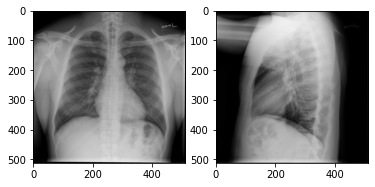

Prediction: no acute abnormality
Caption: no acute abnormality


In [121]:
model.sample(tokenizer)

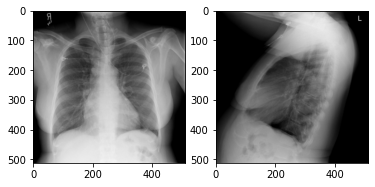

Prediction: mild cardiomegaly no acute pulmonary finding
Caption: mild cardiomegaly no acute pulmonary finding



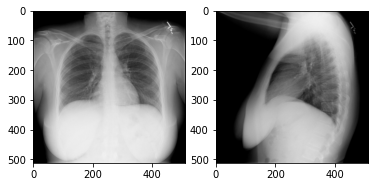

Prediction: no evidence acute cardiopulmonary process
Caption: no evidence acute cardiopulmonary process



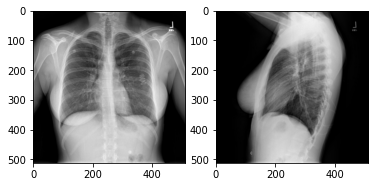

Prediction: no acute radiographic cardiopulmonary process
Caption: no acute radiographic cardiopulmonary process



In [122]:
for _ in range(3):
    model.sample(tokenizer)
    print()

In [123]:
model.evaluate(tokenizer)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'docs.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'docs.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-0s-48-docs.googleusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/usr/local/lib/python3.7/

0.021188224905900017